In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, r2_score, roc_auc_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from scipy import stats
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline
sns.set_theme()

# Project Context and Deliverables

Due to the significant number of baby boomers exploring nursing home options, your company has been tasked with determining whether it is advisable to suggest your client invest in nursing homes. As a member of the data analysis team, you are required to perform an analysis to address this question. Your team has acquired a comprehensive dataset of U.S. nursing homes for the years 2015-2021. Your analysis of this data must address the following topics

**The project has the following deliverable**s:

1. Evaluate the overall financial performance of nursing homes in the United States during this period. (Descriptive Analytics)
2. Identify the influential factors affecting the financial performance of nursing homes.
3. Determine the most significant factors impacting the performance of nursing homes.
4. Describe the trends in performance and these influential factors.
5. Analyze the impact of COVID-19.

---

# Data Loading

Let's consolidate the `CostReport` files into one df. One remark about this task:

- Because years 2015 - 2019 and years 2020 - 2021 do not have the same set of columns (omitting of underscores and slightly different column header names), we will handle each in separate loops, then concat the frames together. This was handled in Excel.
- We will use a `for` loop to make this easier

In [4]:
# Loop through each year, read the CSV file, add a 'Year' column, and append to the list
def get_file_path():
    if os.name == 'nt':  # Windows
        return r'C:\Users\joshu\OneDrive\Desktop Files\Textbooks and Syllabi\CSUN Semester 6\BANA 620\Project\Data'
    else:  # macOS or other Unix-like OS
        return '/Users/josh/Library/CloudStorage/OneDrive-Personal/Desktop Files/Textbooks and Syllabi/CSUN Semester 6/BANA 620/Project/Data'

base_path = get_file_path()
years = ['2015', '2016', '2017', '2018', '2019']
dataframes = []

for year in years:
    file_path = os.path.join(base_path, f'{year}_CostReport.csv')
    df = pd.read_csv(file_path)
    df['Year'] = year  # Add a 'Year' column
    dataframes.append(df)

# Concatenate all DataFrames into one
costReportdf = pd.concat(dataframes, ignore_index=True)

/var/folders/48/zw0lfqs50gq4d0bsvzf3l7tc0000gn/T/ipykernel_57989/54554411.py:14: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [5]:
# 2020 and 2021
base_path = get_file_path()
years = ['2020', '2021']
dataframes = []

for year in years:
    file_path = os.path.join(base_path, f'{year}_CostReport.csv')
    df = pd.read_csv(file_path)
    df['Year'] = year  # Add a 'Year' column
    dataframes.append(df)

# Concatenate all DataFrames into one
costReportdf20to21 = pd.concat(dataframes, ignore_index=True)

costReportdf20to21.head()

,rpt_rec_num,Provider CCN,Facility Name,Street Address,City,State Code,Zip Code,County,Medicare CBSA Number,Rural versus Urban,...,Net Patient Revenue,Less Total Operating Expense,Net Income from service to patients,Total Other Income,Total Income,Net Income,Inpatient PPS Amount,Nursing and Allied Health Education Activities,Allowable Bad Debts,Year
0,1254744,75031,GLEN HILL CENTER,1 GLEN HILL ROAD,DANBURY,CT,06811,FAIRFIELD,14860.0,U,...,1083396.0,1023062.0,60334.0,50.0,60384.0,60384.0,476754.0,NaN,4814.0,2020
1,1255877,495268,MARY WASHINGTON HEALTH CENTER,2400 MCKINNEY BLVD,COLONIAL BEACH,VA,22443,WESTMORELAND,99949.0,R,...,814204.0,1076191.0,-261987.0,806.0,-261181.0,-261181.0,101663.0,NaN,NaN,2020
2,1256270,295107,ADVANCED HEALTH CARE OF PARADISE,3455 PECOS-MCLEOD INTERCONNECT,LAS VEGAS,NV,89121,CLARK,29820.0,U,...,1543399.0,1735321.0,-191922.0,120.0,-191802.0,-191802.0,1263318.0,NaN,NaN,2020
3,1259169,146097,EL PASO HEALTH CARE CENTER,850 EAST SECOND STREET,EL PASO,IL,61738,WOODFORD,37900.0,U,...,877453.0,914701.0,-37248.0,349.0,-36899.0,-36899.0,67241.0,NaN,3876.0,2020
4,1259189,215136,BIRCH MANOR CTR FOR REHAB & HEALTHCA,7309 SECOND AVE,SYKESVILLE,MD,21784,CARROLL,12580.0,U,...,2038599.0,1880948.0,157651.0,20.0,157671.0,157671.0,342853.0,NaN,NaN,2020


In [6]:
# rename columns to match 2015 - 2019 frame
costReportdf20to21.columns = ['rpt_rec_num',
'Provider_CCN',
'Facility_Name',
'Street_Address',
'City',
'State_Code',
'Zip_Code',
'County',
'Medicare_CBSA_Number',
'Rural_versus_Urban',
'Fiscal_Year_Begin_Date',
'Fiscal_Year_End_Date',
'Type_of_Control',
'Total_Days_Title_V',
'Total_Days_Title_XVIII',
'Total_Days_Title_XIX',
'Total_Days_Other',
'Total_Days_Total',
'Number_of_Beds',
'Total_Bed_Days_Available',
'Total_Discharges_Title_V',
'Total_Discharges_Title_XVIII',
'Total_Discharges_Title_XIX',
'Total_Discharges_Title_Other',
'Total_Discharges_Total',
'SNF_Average_Length_of_Stay_Title_V',
'SNF_Average_Length_stay_XVIII',
'SNF_Average_Length_stay_XIX',
'SNF_Average_Length_of_stay_Tot',
'SNF_Admissions_Title_V',
'SNF_Admissions_Title_XVIII',
'SNF_Admissions_Title_XIX',
'SNF_Admissions_Other',
'SNF_Admissions_Total',
'SNF_Days_Title_V',
'SNF_Days_Title_XVIII',
'SNF_Days_Title_XIX',
'SNF_Days_Other',
'SNF_Days_Total',
'SNF_Number_of_Beds',
'SNF_Bed_Days_Available',
'SNF_Discharges_Title_V',
'SNF_Discharges_Title_XVIII',
'SNF_Discharges_Title_XIX',
'SNF_Discharges_Title_Other',
'SNF_Discharges_Total',
'NF_Number_of_Beds',
'NF_Bed_Days_Available',
'NF_Days_Title_V',
'NF_Days_Title_XIX',
'NF_Days_Other',
'NF_Days_Total',
'NF_Discharges_Title_V',
'NF_Discharges_Title_XIX',
'NF_Discharges_Title_Other',
'NF_Discharges_Total',
'NF_Average_Length_of_Stay_Title_V',
'NF_Average_Length_of_Stay_Title_XIX',
'NF_Average_Length_of_Stay_Total',
'NF_Admissions_Title_V',
'NF_Admissions_Title_XIX',
'NF_Admissions_Other',
'NF_Admissions_Total',
'Total_RUG_Days',
'Total_Salaries_From_Worksheet_A',
'Overhead_Non_Salary_Costs',
'Total_Charges',
'Total_Costs',
'Wage_related_Costs_core',
'Total_Salaries_adjusted',
'Contract_Labor',
'Cash_on_hand_and_in_banks',
'Temporary_Investments',
'Notes_Receivable',
'Accounts_Receivable',
'Less:_Allowances_for_uncollectible_notes_and_accounts_receivable',
'Inventory',
'Prepaid_expenses',
'Other_current_assets',
'Total_Current_Assets',
'Land',
'Land_improvements',
'Buildings',
'Leasehold_improvements',
'Fixed_equipment',
'Major_movable_equipment',
'Minor_equipment_depreciable',
'Total_fixed_Assets',
'Investments',
'Other_Assets',
'Total_other_Assets',
'Total_Assets',
'Accounts_payable',
'Salaries_wages_and_fees_payable',
'Payroll_taxes_payable',
'Notes_and_Loans_Payable_(short_term)',
'Deferred_income',
'Other_current_liabilities',
'Total_current_liabilities',
'Mortgage_payable',
'Notes_Payable',
'Unsecured_Loans',
'Other_long_term_liabilities',
'Total_long_term_liabilities',
'Total_liabilities',
'General_fund_balance',
'Total_fund_balances',
'Total_Liab_and_fund_balances',
'Total_General_Inpatient_Revenue',
'Inpatient_Revenue',
'Outpatient_Revenue',
'Gross_Revenue',
'Less_discounts_on_patients',
'Net_Patient_Revenue',
'Less_Total_Operating_Expense',
'Net_Income_from_patients',
'Total_Other_Income',
'Total_Income',
'Net_Income',
'Inpatient_PPS_Amount',
'Nursing_and_Allied_Health_Education_Activities',
'Allowable_Bad_Debts',
'Year']

In [7]:
fullCostReportdf = pd.concat([costReportdf, costReportdf20to21], ignore_index=True)

In [8]:
# dropping columns found only in the 2020 - 2021 set
fullCostReportdf.drop(['Total_Days_Title_V',
 'Total_Discharges_Title_V',
 'SNF_Average_Length_of_Stay_Title_V',
 'SNF_Admissions_Title_V',
 'SNF_Days_Title_V',
 'SNF_Number_of_Beds',
 'SNF_Bed_Days_Available',
 'SNF_Discharges_Title_V',
 'NF_Number_of_Beds',
 'NF_Bed_Days_Available',
 'NF_Days_Title_V',
 'NF_Days_Title_XIX',
 'NF_Days_Other',
 'NF_Days_Total',
 'NF_Discharges_Title_V',
 'NF_Discharges_Title_XIX',
 'NF_Discharges_Title_Other',
 'NF_Discharges_Total',
 'NF_Average_Length_of_Stay_Title_V',
 'NF_Average_Length_of_Stay_Title_XIX',
 'NF_Average_Length_of_Stay_Total',
 'NF_Admissions_Title_V',
 'NF_Admissions_Title_XIX',
 'NF_Admissions_Other',
 'NF_Admissions_Total',
 'Total_Charges',
 'Contract_Labor',
 'Temporary_Investments',
 'Notes_Receivable',
 'Less:_Allowances_for_uncollectible_notes_and_accounts_receivable',
 'Inventory',
 'Prepaid_expenses',
 'Other_current_assets',
 'Total_Current_Assets',
 'Land',
 'Land_improvements',
 'Leasehold_improvements',
 'Minor_equipment_depreciable',
 'Investments',
 'Payroll_taxes_payable',
 'Notes_and_Loans_Payable_(short_term)',
 'Deferred_income',
 'Mortgage_payable',
 'Notes_Payable',
 'Unsecured_Loans',
 'Other_long_term_liabilities',
 'Total_long_term_liabilities',
 'Outpatient_Revenue',
 'Total_Other_Income',
 'Nursing_and_Allied_Health_Education_Activities',
 'Allowable_Bad_Debts'], axis=1, inplace=True)

In [9]:
# convert column headers to all lower for consistentcy
fullCostReportdf.columns = fullCostReportdf.columns.str.lower()

In [10]:
# # Save file for reference and for use in Tableau / PowerBI
# output_path = r'C:\Users\joshu\OneDrive\Desktop Files\Textbooks and Syllabi\CSUN Semester 6\BANA 620\Project\Data\Consolidated_CostReport.csv'
# fullCostReportdf.to_csv(output_path, index=False)

## Data Cleaning and Preprocessing

### Identifying and handling outliers.

In [11]:
# dealing with a subset of outliers by z-score threshold
def removeOutliers(input_df, column_name, zScoreThreshold):
    mean = input_df[column_name].mean()
    std = input_df[column_name].std()
    z_scores = (input_df[column_name] - mean) / std

    return input_df[(z_scores > -zScoreThreshold) & (z_scores < zScoreThreshold)]

numerical_columns = ['net_income', 'accounts_payable']
for each in numerical_columns:
   df = removeOutliers(fullCostReportdf, each, 3)

There are also some suspect records based on data entry. Looking at bed counts:

In [12]:
bedList = df['number_of_beds'].sort_values(ascending=False)
bedList.to_frame()
bedList.head(15)

43153    12043800.0
83260       71430.0
38005       54385.0
69707       28470.0
41132       28470.0
54900       28470.0
54460       27375.0
38666       23964.0
93395       22287.0
73501       21900.0
46990       21900.0
79098        5892.0
16058        5254.0
28919        5178.0
89460        3103.0
Name: number_of_beds, dtype: float64

We will delete the records which report 21k beds or more.

In [13]:
bedThreshold = 21000

# Filter the DataFrame to keep only the rows where 'Number_of_Beds' is less than or equal to the threshold
df = df[df['number_of_beds'] <= bedThreshold]

### Dropping null records

In [14]:
# viewing the nulls before cleaning
def getNulls():
    nullList = df.isna().sum()

    nullFrame = pd.DataFrame(nullList, columns=['nullCount'])
    nullFrame.reset_index(inplace=True)

    nullFrame.columns = ['feature', 'nullCount']
    nullFrame = nullFrame[nullFrame['nullCount'] != 0]
    
    return nullFrame
    
getNulls()

,feature,nullCount
3,street_address,9
8,medicare_cbsa_number,47
9,rural_versus_urban,112
13,accounts_receivable,1903
15,buildings,59348
16,cash_on_hand_and_in_banks,1486
17,general_fund_balance,239
18,gross_revenue,6
19,inpatient_pps_amount,99
20,inpatient_revenue,6


In [15]:
dropnaList = ['gross_revenue', 'net_income', 'total_assets', 'total_costs', 'total_discharges_total', 'total_income', 'total_liab_and_fund_balances', 'rural_versus_urban', 'accounts_receivable']
df.dropna(subset=dropnaList, inplace=True)

### Culling columns
We will drop the following:

Dropping due to large percentage (more than 10%) of `null` values:
- `buildings`
- `major_moveable_equipment`
- `fixed_equipment`
- `'snf_admissions_title_xix'`
- `'snf_average_length_stay_xix`'
- `'snf_days_title_xix`'
- `'snf_discharges_title_xix`'
- `'snf_bed_days_available`'
- `'snf_number_of_beds`'
- `'total_days_title_xix`'
- `'total_discharges_title_xix`'
- `'total_rug_days`'

Dropping due to irrelevance to target feature:
- Identifiers

Dropping due to redundancy:
- Captured by `year`:
    - `fiscal_year_begin_date`
    - `fiscal_year_end_date`
- Captured within `total_assets` (definition of `total_assets` in data dictionary):
    - `other_assets`
    - `'total_current_assets'`
    - `'total_fixed_assets'`
    - `'total_other_assets'`

- `'total_salaries_from_worksheet_a',`: duplicate with `'total_salaries_adjusted'`

In [16]:
dropNull = ['buildings', 'major_movable_equipment', 'fixed_equipment', 'snf_admissions_title_xix', 'snf_average_length_stay_xix', 'snf_days_title_xix', 'snf_discharges_title_xix', 'snf_bed_days_available', 'snf_number_of_beds', 'total_days_title_xix', 'total_discharges_title_xix', 'total_rug_days']
dropRedundancy = ['fiscal_year_begin_date', 'fiscal_year_end_date', 'other_assets', 'total_current_assets', 'total_fixed_assets', 'total_other_assets', 'total_salaries_from_worksheet_a', 'other_current_liabilities']
dropInsignificant = []
dropList = dropNull + dropRedundancy + dropInsignificant

In [17]:
df.columns.to_list()

['rpt_rec_num',
 'provider_ccn',
 'facility_name',
 'street_address',
 'city',
 'state_code',
 'zip_code',
 'county',
 'medicare_cbsa_number',
 'rural_versus_urban',
 'fiscal_year_begin_date',
 'fiscal_year_end_date',
 'type_of_control',
 'accounts_receivable',
 'accounts_payable',
 'buildings',
 'cash_on_hand_and_in_banks',
 'general_fund_balance',
 'gross_revenue',
 'inpatient_pps_amount',
 'inpatient_revenue',
 'less_total_operating_expense',
 'less_discounts_on_patients',
 'major_movable_equipment',
 'net_income',
 'net_income_from_patients',
 'net_patient_revenue',
 'number_of_beds',
 'other_assets',
 'other_current_liabilities',
 'overhead_non_salary_costs',
 'snf_admissions_other',
 'snf_admissions_title_xix',
 'snf_admissions_title_xviii',
 'snf_admissions_total',
 'snf_average_length_of_stay_tot',
 'snf_average_length_stay_xix',
 'snf_average_length_stay_xviii',
 'snf_days_other',
 'snf_days_title_xix',
 'snf_days_title_xviii',
 'snf_days_total',
 'snf_discharges_title_other',

In [18]:
df.drop(columns=dropList, inplace=True, axis=1)

In [19]:
# viewing nulls after column culling
getNulls()

,feature,nullCount
3,street_address,9
8,medicare_cbsa_number,45
13,cash_on_hand_and_in_banks,1445
14,general_fund_balance,64
16,inpatient_pps_amount,76
19,less_discounts_on_patients,5836
25,snf_admissions_other,1656
26,snf_admissions_title_xviii,857
27,snf_admissions_total,596
28,snf_average_length_of_stay_tot,10


### Handling Remaining Nulls: Mean Imputation

Because the remaining number of remaining null values is quite low relative to the data set, let's handle these with mean imputation. 

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98610 entries, 0 to 106267
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   rpt_rec_num                      98610 non-null  int64  
 1   provider_ccn                     98610 non-null  int64  
 2   facility_name                    98610 non-null  object 
 3   street_address                   98601 non-null  object 
 4   city                             98610 non-null  object 
 5   state_code                       98610 non-null  object 
 6   zip_code                         98610 non-null  object 
 7   county                           98610 non-null  object 
 8   medicare_cbsa_number             98565 non-null  object 
 9   rural_versus_urban               98610 non-null  object 
 10  type_of_control                  98610 non-null  float64
 11  accounts_receivable              98610 non-null  float64
 12  accounts_payable 

### Null String: imputation of `missing`

In [21]:
df['street_address'].fillna(value="missing", inplace=True)
df['medicare_cbsa_number'].fillna(value="missing", inplace=True)

nullFrame = getNulls()

meanImputationList = nullFrame['feature'].tolist()
meanImputationList

for each in meanImputationList:
    df[each].fillna(round(df[each].mean()), inplace=True)

In [22]:
df.columns.to_list()

['rpt_rec_num',
 'provider_ccn',
 'facility_name',
 'street_address',
 'city',
 'state_code',
 'zip_code',
 'county',
 'medicare_cbsa_number',
 'rural_versus_urban',
 'type_of_control',
 'accounts_receivable',
 'accounts_payable',
 'cash_on_hand_and_in_banks',
 'general_fund_balance',
 'gross_revenue',
 'inpatient_pps_amount',
 'inpatient_revenue',
 'less_total_operating_expense',
 'less_discounts_on_patients',
 'net_income',
 'net_income_from_patients',
 'net_patient_revenue',
 'number_of_beds',
 'overhead_non_salary_costs',
 'snf_admissions_other',
 'snf_admissions_title_xviii',
 'snf_admissions_total',
 'snf_average_length_of_stay_tot',
 'snf_average_length_stay_xviii',
 'snf_days_other',
 'snf_days_title_xviii',
 'snf_days_total',
 'snf_discharges_title_other',
 'snf_discharges_title_xviii',
 'snf_discharges_total',
 'salaries_wages_and_fees_payable',
 'total_assets',
 'total_bed_days_available',
 'total_costs',
 'total_days_other',
 'total_days_title_xviii',
 'total_days_total',
 

Now that the cleaning is complete, let's perform some eploratory data analysis.

# EDA

## Feature Engineering
Several features which can be useful metrics for determing financial health need to be calculated:

1. **Revenue Growth:**
    - You can calculate the year-over-year percentage change in **`gross_revenue`**.
2. **Profit Margins:**
    - Gross Profit Margin: (**`gross_revenue`** - **`total_costs`**) / **`gross_revenue`**.
    - Net Profit Margin: **`net_income`** / **`gross_revenue`**.
3. **Operational Efficiency:**
    - Total Operating Expense Ratio: **`less_total_operating_expense`** / **`gross_revenue`**.
4. **Liquidity Ratios:**
    - Current Ratio: **`total_current_assets`** / **`total_current_liabilities`**.
5. **Solvency Ratios:**
    - Debt-to-Equity Ratio: **`total_liabilities`** / **`total_fund_balances`**.
6. **Return on Investment (ROI):**
    - ROI: **`net_income`** / **`total_assets`**.
7. **Capacity Utilization:**
    - Bed Occupancy Rate: **`total_days_total`** / (**`number_of_beds`** * 365).
8. **Cost Management:**
    - Cost per Bed: **`total_costs`** / **`number_of_beds`**.
    - Salary Costs per Bed: **`total_salaries_adjusted`** / **`number_of_beds`**.

In [23]:
# Adding financial metrics calculations
df['gross_profit_margin'] = (df['gross_revenue'] - df['total_costs']) / df['gross_revenue']
df['net_profit_margin'] = df['net_income'] / df['gross_revenue']
df['operating_expense_ratio'] = df['total_costs'] / df['gross_revenue']
df['assets_to_liability_ratio'] = df['total_assets'] / df['total_liabilities']
df['debt_to_equity_ratio'] = df['total_liabilities'] / df['total_fund_balances']
df['roi'] = df['net_income'] / df['total_assets']
df['bed_occupancy_rate'] = df['total_days_total'] / (df['number_of_beds'] * 365)
df['cost_per_bed'] = df['total_costs'] / df['number_of_beds']
df['salary_costs_per_bed'] = df['total_salaries_adjusted'] / df['number_of_beds']
df['bed_utilization_rate'] = df['total_days_total'] / df['total_bed_days_available']

Creating these features let's us identify some more outlier records that would negatively impact model performance. We address the following:

In [24]:
costPerBedThreshold = 200000

# Filter the DataFrame to keep only the rows where 'Number_of_Beds' is less than or equal to the threshold
df = df[df['cost_per_bed'] <= costPerBedThreshold]

In [25]:
df = df[df['operating_expense_ratio'] <= 2]
df = df[df['operating_expense_ratio'] >= -2]

In [26]:
# windows path
# output_path_feat_engineer = r'C:\Users\joshu\OneDrive\Desktop Files\Textbooks and Syllabi\CSUN Semester 6\BANA 620\Project\Data\CostReportFeatEngineer.csv'

#macos path
#output_path_feat_engineer = '/Users/josh/Library/CloudStorage/OneDrive-Personal/Desktop Files/Textbooks and Syllabi/CSUN Semester 6/BANA 620/Project/Data/CostReportFeatEngineer.csv'

# df.to_csv(output_path_feat_engineer, index=False)

## Financial Performance Metrics Analysis

/var/folders/48/zw0lfqs50gq4d0bsvzf3l7tc0000gn/T/ipykernel_57989/2238099130.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.barplot(x=group_by_column, y=column, data=df.groupby(group_by_column).mean().reset_index())
/var/folders/48/zw0lfqs50gq4d0bsvzf3l7tc0000gn/T/ipykernel_57989/2238099130.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.barplot(x=group_by_column, y=column, data=df.groupby(group_by_column).mean().reset_index())
/var/folders/48/zw0lfqs50gq4d0bsvzf3l7tc0000gn/T/ipykernel_57989/2238099130.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is depr

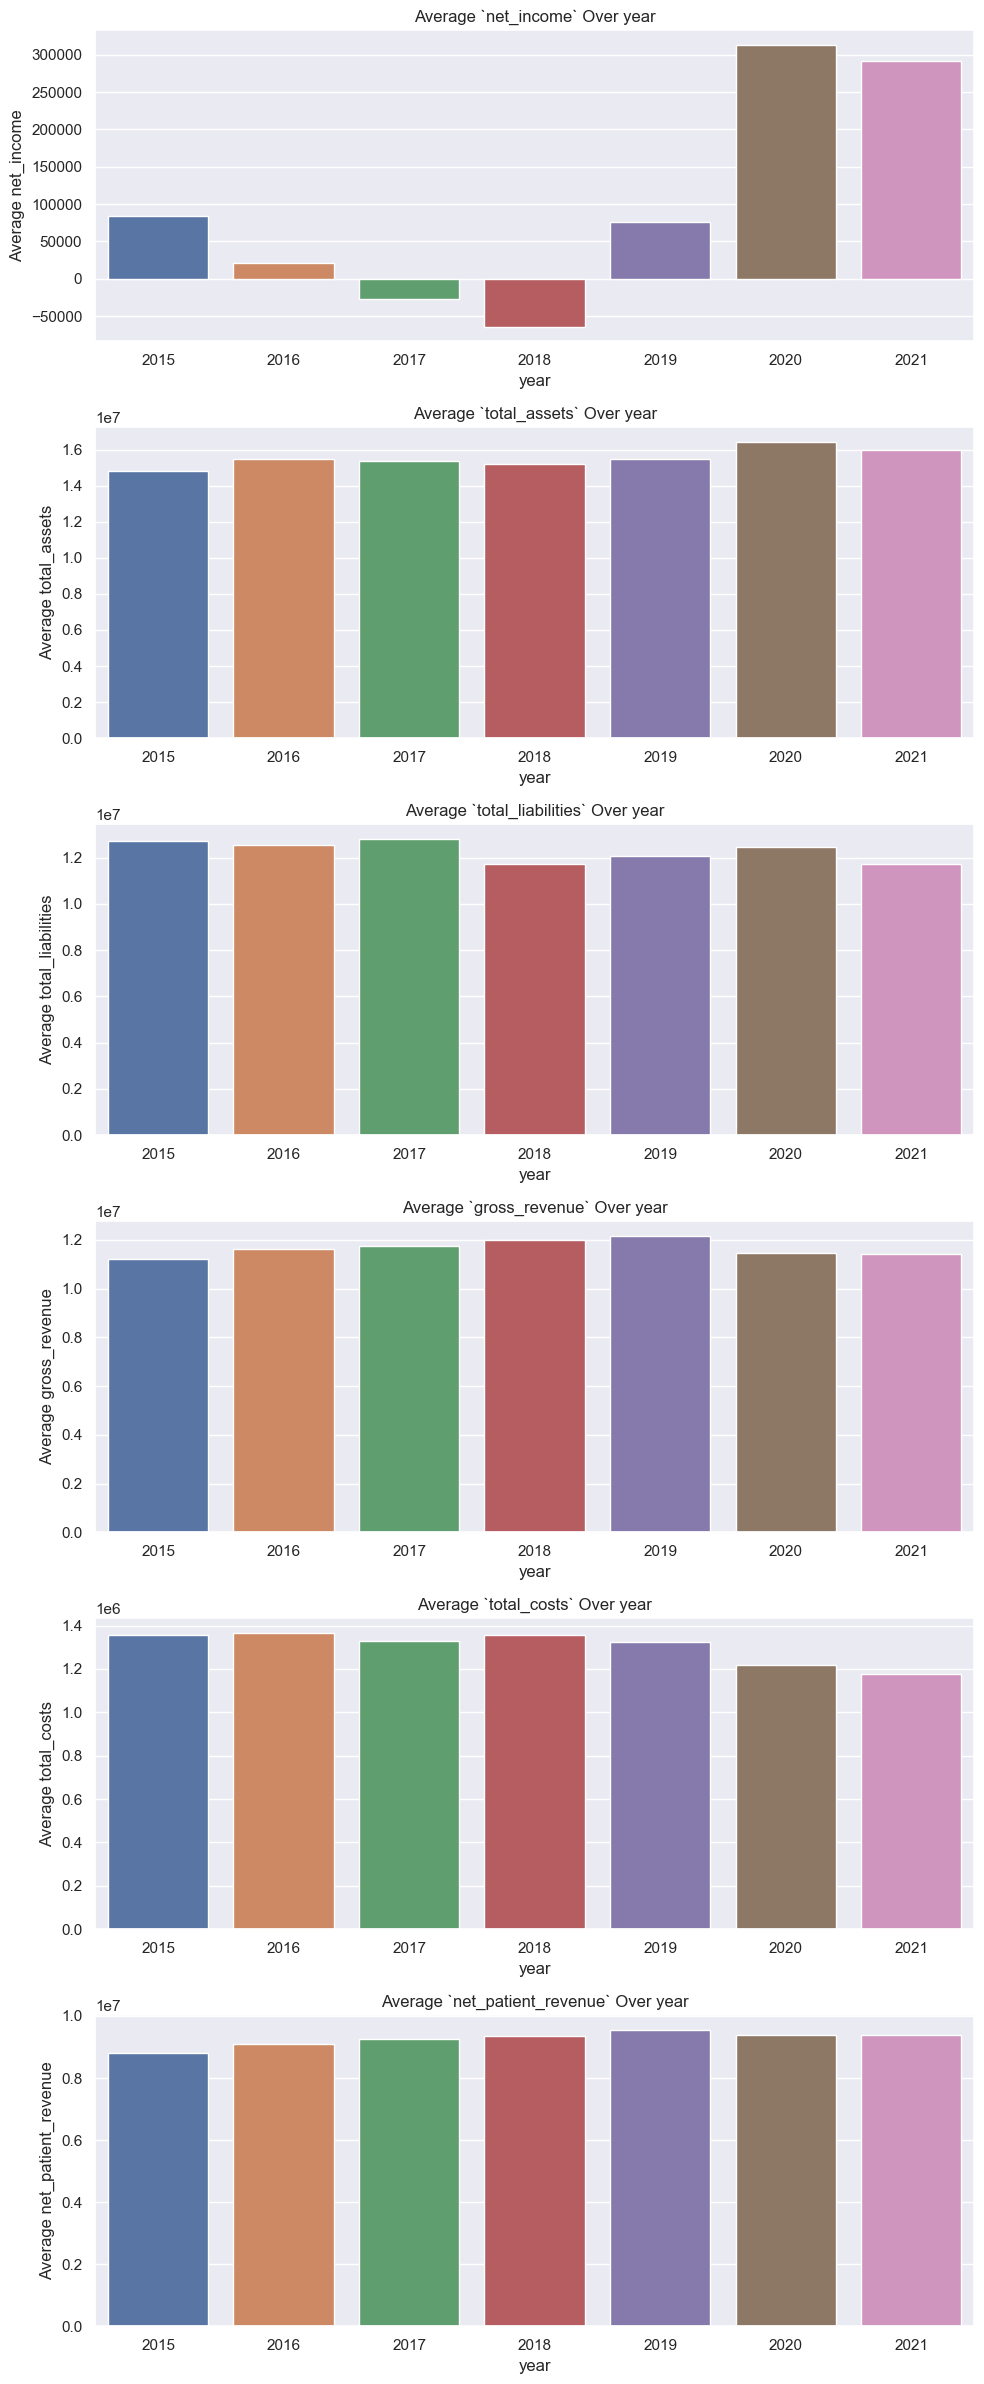

In [27]:
def plot_numerical_features_over_time(df, numerical_columns, group_by_column):
    """
    Plots line graphs for each numerical feature in the DataFrame grouped by the specified column.
    
    Parameters:
    - df: DataFrame containing the data.
    - numerical_columns: List of column names for numerical features to plot.
    - group_by_column: Column name to group the data by (e.g., 'Year').
    """
    # Set the size of the plots
    plt.figure(figsize=(10, len(numerical_columns) * 4))
    
    # Iterate over each numerical feature and create a subplot
    for i, column in enumerate(numerical_columns, 1):
        plt.subplot(len(numerical_columns), 1, i)
        sns.barplot(x=group_by_column, y=column, data=df.groupby(group_by_column).mean().reset_index())
        plt.title(f'Average `{column}` Over {group_by_column}')
        plt.xlabel(group_by_column)
        plt.ylabel(f'Average {column}')
        plt.tight_layout()
    
    # Show the plots
    plt.show()
    
numerical_features = ['net_income', 'total_assets', 'total_liabilities', 'gross_revenue', 'total_costs', 'net_patient_revenue']
plot_numerical_features_over_time(df, numerical_features, 'year')

/var/folders/48/zw0lfqs50gq4d0bsvzf3l7tc0000gn/T/ipykernel_57989/391814143.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


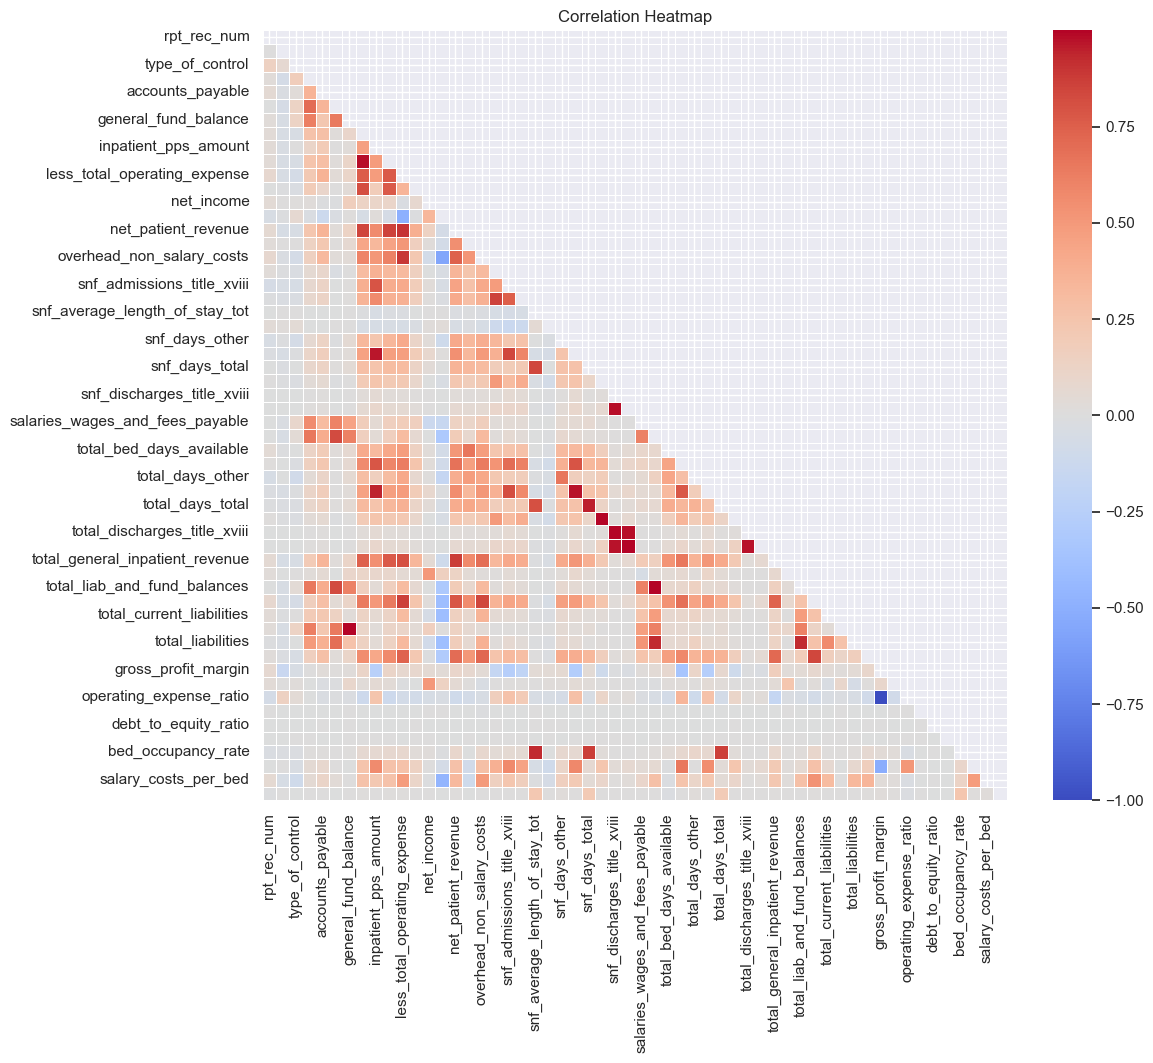

In [28]:
corr_matrix = df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm", 
            mask=mask, cbar=True, linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

<Axes: xlabel='number_of_beds', ylabel='net_income'>

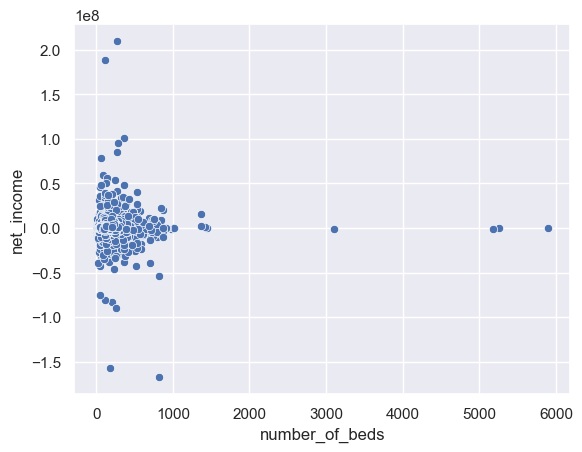

In [29]:
sns.scatterplot(data=df, x='number_of_beds', y='net_income')

# Model Building

Let's do some preliminary tasks before we input input our models.
- Drop some more columns
- StandardScaler()
- One-hot encoding

In [30]:
# this drops data such as identifiers, redundant addresses
preModelDropList = ['rpt_rec_num',
 'provider_ccn',
 'facility_name',
 'street_address',
 'city',
 'zip_code',
 'county', 
 'medicare_cbsa_number',
 'year']

In [31]:
df.drop(columns = preModelDropList, inplace = True, axis = 1)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98600 entries, 0 to 106267
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   state_code                       98600 non-null  object 
 1   rural_versus_urban               98600 non-null  object 
 2   type_of_control                  98600 non-null  float64
 3   accounts_receivable              98600 non-null  float64
 4   accounts_payable                 98600 non-null  float64
 5   cash_on_hand_and_in_banks        98600 non-null  float64
 6   general_fund_balance             98600 non-null  float64
 7   gross_revenue                    98600 non-null  float64
 8   inpatient_pps_amount             98600 non-null  float64
 9   inpatient_revenue                98600 non-null  float64
 10  less_total_operating_expense     98600 non-null  float64
 11  less_discounts_on_patients       98600 non-null  float64
 12  net_income       

In [33]:
numericalFeatures = df.select_dtypes(exclude=['object']).columns.to_list()
numericalFeatures.remove('net_income')
categoricalFeatures = df.select_dtypes(include=['object']).columns.to_list()

In [34]:
for each in categoricalFeatures:
    df = pd.concat([df, pd.get_dummies(df[each], prefix=each)], axis = 1)
    
df.drop(columns=categoricalFeatures, inplace=True, axis=1)

In [35]:
X = df.drop(['net_income'], axis=1)
y = df['net_income']

scaler = StandardScaler()
X[numericalFeatures] = scaler.fit_transform(X[numericalFeatures])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123) # create training and testing sets

## Extremely Simple Models:
- Linear Regression
- Ridge
- Lasso
- KNN
- Random Forest

In [36]:
lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
# Evaluating the model
mse = mean_squared_error(y_test, y_pred_lr)
r2 = r2_score(y_test, y_pred_lr)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Displaying the coefficients
# print('Intercept:', lr.intercept_)
# print('Coefficients:', lr.coef_)

Mean Squared Error: 3985479508232.4043
R-squared: 0.4144867865141031


In [37]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha = 20000)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f'MSE Ridge: {mse_ridge}')
print(f'r2 Ridge: {r2_ridge}')
# print(f'Coefficients: {ridge_model.coef_}')

MSE Ridge: 3092800833798.9673
r2 Ridge: 0.5456316483050657


In [38]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha = 20000)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

feature_names = X_train.columns
coefficients = lasso_model.coef_
lasso_features = dict(zip(feature_names, coefficients))

print(f'MSE lasso: {mse_lasso}')
print(f'r2 lasso: {r2_lasso}')
print(f'Coefficients: {lasso_model.coef_}')

lasso_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
lasso_df

MSE lasso: 2790558988774.325
r2 lasso: 0.5900344845421465
Coefficients: [     -0.         -122310.77410823   -8814.70064946 -169319.23808962
  411501.87923857   89796.25852692  172476.13175408  -74483.53742539
       0.          169772.46972767  691732.92656143       0.
       0.              -0.          -25614.40789784  -85937.9130893
      -0.              -0.               0.               0.
       0.              -0.              -0.              -0.
      -0.         -225283.82365018  162184.04176316      -0.
 -102661.41594628   17160.31373911      -0.              -0.
      -0.              -0.              -0.              -0.
  703065.50681823       0.          140524.12564591   83223.67631048
       0.               0.          -49125.01303085  -66239.8618026
  832315.21107433   42285.28462853       0.               0.
       0.              -0.         -130258.5823177   208306.29492601
      -0.              -0.              -0.               0.
       0.               0.  

,Feature,Coefficient
0,type_of_control,-0.000000
1,accounts_receivable,-122310.774108
2,accounts_payable,-8814.700649
3,cash_on_hand_and_in_banks,-169319.238090
4,general_fund_balance,411501.879239
...,...,...
102,state_code_WI,-0.000000
103,state_code_WV,0.000000
104,state_code_WY,-0.000000
105,rural_versus_urban_R,0.000000


In [39]:
from sklearn.linear_model import ElasticNet

elastic_net_model = ElasticNet(alpha=1.0, l1_ratio=0.5)
elastic_net_model.fit(X_train, y_train)
y_pred_en = elastic_net_model.predict(X_test)
mse_en = mean_squared_error(y_test, y_pred_en)
r2_en = r2_score(y_test, y_pred_en)

print(f'MSE Elastic Net: {mse_en}')
print(f'R2 Elastic Net: {r2_en}')


MSE Elastic Net: 3501573914130.5425
R2 Elastic Net: 0.4855781367120229


In [40]:
# this codeblock currently takes a very long time to run
# from sklearn.ensemble import RandomForestRegressor

# random_forest_model = RandomForestRegressor(n_estimators=100)
# random_forest_model.fit(X_train, y_train)
# y_pred_rf = random_forest_model.predict(X_test)
# mse_rf = mean_squared_error(y_test, y_pred_rf)
# r2_rf = r2_score(y_test, y_pred_rf)

# print(f'MSE Random Forest: {mse_rf}')
# print(f'R2 Random Forest: {r2_rf}')

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_boosting_model = GradientBoostingRegressor(n_estimators=100)
gradient_boosting_model.fit(X_train, y_train)
y_pred_gb = gradient_boosting_model.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'R2 Gradient Boosting: {r2_gb}')
print('MSE Gradient Boosting: {:0.3f}'.format(mse_gb/1e6))

# print("Train MSE: {:0.3f} \nTest MSE: {:0.3f}".format(train_mse/1e6, test_mse/1e6))

R2 Gradient Boosting: 0.8694540603427459
MSE Gradient Boosting: 888601.923


In [42]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=1)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f'MSE KNN: {mse_knn}')
print(f'R2 KNN: {r2_knn}')


AttributeError: 'NoneType' object has no attribute 'split'

### Refinement
We have been passing all features through the models. For models that don't have any type of regularization, this can easily result in overfitting. Let's go through some methods to get the more important features relative to the target variable `net_income`

In the `lasso` model we got a DataFrame (`lasso_df`) of the features and their coeffiients. Many feature coefficients were set to 0, so let's take the ones that were not set to zero and rerun the models

In [43]:
lasso_df['Feature']

0                type_of_control
1            accounts_receivable
2               accounts_payable
3      cash_on_hand_and_in_banks
4           general_fund_balance
                 ...            
102                state_code_WI
103                state_code_WV
104                state_code_WY
105         rural_versus_urban_R
106         rural_versus_urban_U
Name: Feature, Length: 107, dtype: object